This model would be used to classify the rare points(loyalty score <= -30). This would help us identify these points and predict the loyalty scores better.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Applied\ AI\ course\ Assignments/Case\ Study\ 1

/content/drive/My Drive/Applied AI course Assignments/Case Study 1


In [ ]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=ca90c0b9eda19603bd296549adba0464af68a0d2cc422e29e5b8140f07cc6f43
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedKFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import pickle

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, log_loss, confusion_matrix, plot_confusion_matrix

import time
import gc
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Probability based Stack Model architecture:

Ref: https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/82314

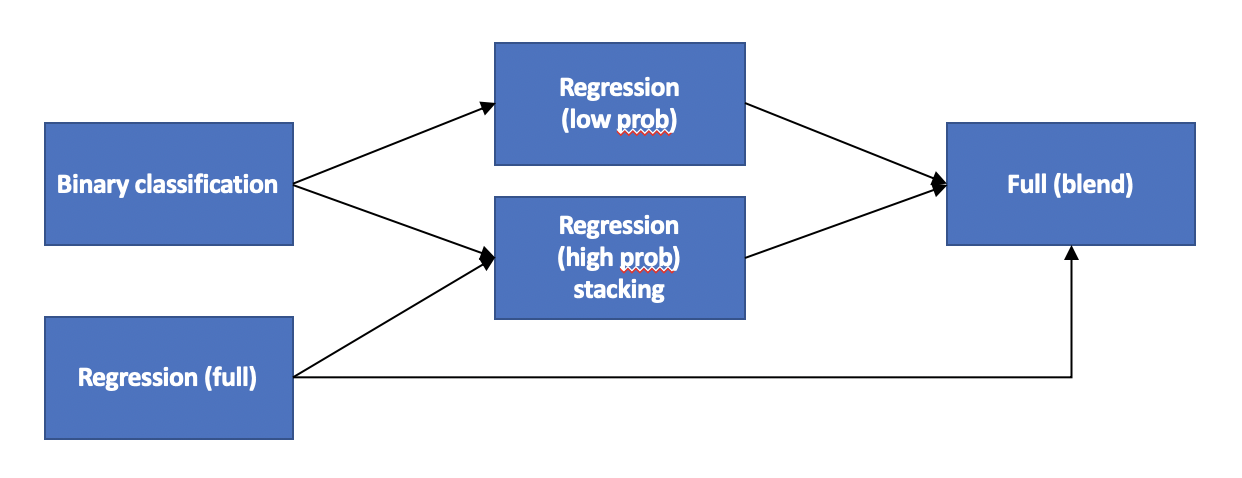

## Loading the data

In [ ]:
train = reduce_mem_usage(pd.read_csv('New_Data_processed/train_features_without_merchant.csv', index_col=0))
test = reduce_mem_usage(pd.read_csv('New_Data_processed/test_features_without_merchant.csv', index_col=0))

Mem. usage decreased to 99.94 Mb (71.4% reduction)
Mem. usage decreased to 62.01 Mb (70.9% reduction)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Columns: 226 entries, card_id to new_CLV
dtypes: float16(172), float32(5), float64(10), int16(15), int32(2), int8(21), object(1)
memory usage: 99.9+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123623 entries, 0 to 123622
Columns: 225 entries, card_id to new_CLV
dtypes: float16(171), float32(8), float64(10), int16(12), int32(3), int8(20), object(1)
memory usage: 62.0+ MB


In [ ]:
train.isna().sum().any()

False

In [ ]:
test.isna().any().sum() #target variable is Nan

3

In [ ]:
test['new_purchase_date_diff_now'].fillna(test['new_purchase_date_diff_now'].mode()[0], inplace=True) 
test['new_last_buy'].fillna(test['new_last_buy'].mode()[0], inplace=True) 

In [ ]:
test.columns[test.isna().any()]

Index(['target'], dtype='object')

In [ ]:
y_data = train['rare_datapoints']
train.drop(columns=['rare_datapoints', 'card_id', 'target'], axis=1, inplace=True)

In [ ]:
y_data.value_counts()

0    199710
1      2207
Name: rare_datapoints, dtype: int64

In [ ]:
test.drop(columns=['card_id', 'target'], axis=1, inplace=True)

## Hypertuning the model

In [ ]:
def LGBM_CV(
            num_leaves,
            max_depth,
            n_estimators,
            min_split_gain,
            subsample,
            min_child_samples,
            colsample_bytree,
            reg_alpha,
            reg_lambda
):

  folds = StratifiedKFold(n_splits = 3, shuffle=True, random_state=5)
  oof = np.zeros(train.shape[0])

  for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("Fold:", fold_)
    trn_data = lgb.Dataset(train.iloc[train_idx], label = y_data.iloc[train_idx])
    val_data = lgb.Dataset(train.iloc[val_idx], label = y_data.iloc[val_idx])

    params = {  
                'task': 'train',
                'objective' : 'binary',
                'boosting_type' : 'goss',
                'num_leaves' : int(num_leaves),
                'max_depth' : int(max_depth),
                'learning_rate' : 0.01,
                'n_estimators' : int(n_estimators),
                'is_unbalance' : True,
                'min_split_gain' : min_split_gain,
                'subsample' : subsample,
                'min_child_samples' : int(min_child_samples),
                'colsample_bytree' : colsample_bytree,
                'n_jobs' : -1,
                'reg_alpha' : reg_alpha,
                'reg_lambda' : reg_lambda,
                'metric': 'binary_logloss'
    }

    clf = lgb.train(params,
                    trn_data,
                    valid_sets = [trn_data, val_data],
                    verbose_eval = 1000,
                    early_stopping_rounds = 200
                    )
    
    oof[val_idx] = clf.predict(train.iloc[val_idx])
  
  #oof = np.where(oof > 0.5, 1, 0) # Change predictions to 0-1 output
  #Change the error metric if needed
  return -log_loss(y_data, oof)

In [ ]:
LGB_BO = BayesianOptimization(LGBM_CV, {
    'min_split_gain': (0, 1),
    'subsample': (0, 1) ,
    'min_child_samples': (10, 200),
    'colsample_bytree': (0, 1),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
    'max_depth': (4, 10),
    'num_leaves': (5, 200),
    'n_estimators' : (10, 750)
    })



In [ ]:
start_time = time.time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=30, acq='ei', xi=0.0)
    
print("Time taken", time.time()-start_time)
print('-'*130)
print('Final Results')
print('Maximum  value: %f' % LGB_BO.max['target'])
print('Best  parameters: ', LGB_BO.max['params'])

|   iter    |  target   | colsam... | max_depth | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Fold: 0
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[2]	training's binary_logloss: 0.0567351	valid_1's binary_logloss: 0.0554363
Fold: 1
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[2]	training's binary_logloss: 0.0565075	valid_1's binary_logloss: 0.0558807
Fold: 2
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[2]	training's binary_logloss: 0.0550725	valid_1's binary_logloss: 0.0577161
|  1        | -0.1239   |  0.125    |  4.001    |  101.8    |  0.9643   |  163.5    |  155.4    |  0.7511   |  0.3077   |  0.2372   |
Fold: 0
Tr

## Training with the best parameters

In [ ]:
params = {
          'colsample_bytree': 0.722967786681799, 
          'max_depth': 9, 
          'min_child_samples': 15, 
          'min_split_gain': 0.856062296002521, 
          'n_estimators': 747, 
          'num_leaves': 198, 
          'reg_alpha': 0.4520877630953888, 
          'reg_lambda': 0.07735875905930989, 
          'subsample': 0.4539292962975947
          }

Predict with OOF

In [ ]:

#train_preds = np.zeros(X_train.shape[0])
#test_predictions = np.zeros(X_test.shape[0])

trn_data = lgb.Dataset(train, label = y_data)

'''clf = lgbLGBMClassifier (
    is_unbalance = True,
    colsample_bytree = 0.6813895741400308, 
    max_depth = 9, 
    min_child_samples = 18, 
    min_split_gain = 0.8550956688228781, 
    n_estimators = 60, 
    num_leaves = 197, 
    reg_alpha = 0.5414829105846717, 
    reg_lambda = 0.3324063671273374, 
    subsample = 0.5169590052072766
)

clf.fit(X_train, y_train)

'''
clf = lgb.train(params,
                trn_data,
                10000,
                verbose_eval=500
                )

In [ ]:
train_preds = clf.predict(train)

### Save the model

In [ ]:
with open('Binary_Classification.pkl', 'wb') as f:
  pickle.dump(clf, f)

In [ ]:
#Load the model

with open('Binary_Classification.pkl', 'rb') as f:
  clf = pickle.load(f)
  

## Results:


### AUC score and plot:

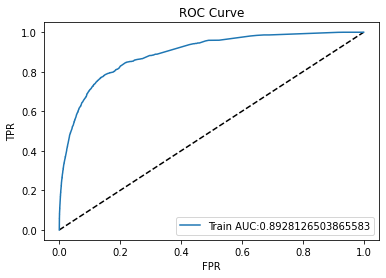

In [ ]:
plt.plot([0,1],[0,1], 'k--')


#Train AUC
fpr, tpr, threshold = roc_curve(y_data, train_preds)
auc_score = roc_auc_score(y_data, train_preds)
plt.plot(fpr, tpr, label="Train AUC:"+str(auc_score))


plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

### Confusion matrix

In [ ]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        plt.grid(False)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

Train accuracy: 0.8917376942010826
**************************************************


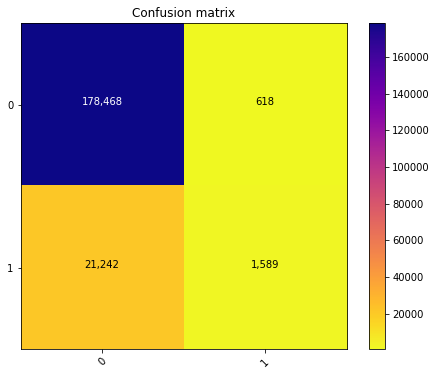

In [ ]:
#This is decided based on trial and error
threshold = 0.020
train_pred_labels = np.where(train_preds > threshold, 1, 0)
#test_predictions_labels = np.where(test_predictions > threshold, 1, 0)

print("Train accuracy:", accuracy_score(train_pred_labels, y_data))
print('*'*50)
plot_confusion_matrix(confusion_matrix(train_pred_labels, y_data), target_names=[0,1], normalize=False, cmap= plt.get_cmap('plasma_r'))


In [ ]:
#Load the model

with open('Binary_Classification.pkl', 'rb') as f:
  clf = pickle.load(f)

## Prob predictions for actual test data:

In [ ]:
train_prob = clf.predict(train)
test_prob = clf.predict(test)

threshold = 0.020

train_labels = np.where(train_prob > threshold, 1, 0)
test_labels = np.where(test_prob > threshold, 1, 0)

In [ ]:
# Check accuracy on the train data

print("Accuracy on entire train data:", accuracy_score(train_labels, y_data))

Accuracy on entire train data: 0.8917376942010826


In [ ]:
# Saving our predictions for further use
with open('prob_labels_train.pkl', 'wb') as f:
  pickle.dump(train_prob, f)

with open('prob_labels_test.pkl', 'wb') as f:
  pickle.dump(test_prob, f)


In [ ]:
# Saving our predictions for further use
with open('predicted_labels_train.pkl', 'wb') as f:
  pickle.dump(train_labels, f)

with open('predicted_labels_test.pkl', 'wb') as f:
  pickle.dump(test_labels, f)
